In [1]:
import pandas as pd



# df=pd.read_csv("df_final_2.csv")

X_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, :-1]

y_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, -1]

X_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, :-1]

y_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, -1]

In [2]:
from sklearn.preprocessing import PolynomialFeatures



def get_aggregations(df, column_groupby, column_agg):



    if not isinstance(column_agg, list):

        column_agg = [column_agg]

    

    # Create the aggregation dictionary

    aggregation_dict = {}

    for col in column_agg:

        aggregation_dict.update({

            f'Median_{col}': (col, 'median'),

            f'Max_{col}': (col, 'max'),

            f'Min_{col}': (col, 'min'),

            f'Sum_{col}': (col, 'sum'),

            f'Std_{col}': (col, 'std'),

            f'Mean_{col}': (col, 'mean')

        })

    

    # Perform groupby and aggregation

    df_agg = df.groupby(column_groupby).agg(**aggregation_dict).reset_index()



    return df_agg



def get_polynomial_features(df, columns, degree=2):

    

    if not isinstance(columns, list):

        columns = [columns]

    # Initialize PolynomialFeatures with specified degree

    poly = PolynomialFeatures(degree=degree, include_bias=False)

    

    # Select columns and generate polynomial features

    poly_features = df[columns]

    poly_array = poly.fit_transform(poly_features)

    

    # Get feature names and create DataFrame from polynomial array

    poly_feature_names = poly.get_feature_names_out(columns)

    poly_df = pd.DataFrame(poly_array, columns=poly_feature_names, index=df.index)

    

    # Concatenate the original DataFrame with polynomial features

    df_with_poly = pd.concat([df, poly_df], axis=1)

Physical-Systolic_BP - min \

Physical-Diastolic_BP - min \

FGC-FGC_CU - median

In [3]:
from sklearn.preprocessing import PolynomialFeatures



column_groupby = 'PCIAT-PCIAT_Total'

column_agg=['FGC-FGC_CU','Physical-Systolic_BP','Physical-Diastolic_BP']

# column_agg='FGC-FGC_CU'



df_agg = get_aggregations(X_train, column_groupby=column_groupby, column_agg=column_agg)



for column in df_agg.columns:

    df_agg[column] = df_agg[column].fillna(df_agg[column].mean())



# # Verificar pra calcular separadamente ou tudo junto polinomios e relacoes se adicionar mais de uma coluna

# poly_df = get_polynomial_features(df_agg, columns=column_agg, degree=2)



# df_agg = pd.concat([df_agg, poly_df], axis=1)

In [4]:
print(f'Features with highest correlation to {column_groupby} \n')

columns_corr=[]

for column in column_agg:



    corr_df = df_agg.loc[:, df_agg.columns[df_agg.columns.str.endswith(column)].tolist()]

    corr_df[column_groupby] = df_agg[column_groupby]

    correlation_matrix = corr_df.corr()

    feature_highest_corr = correlation_matrix[column_groupby].drop(column_groupby).abs().idxmax()

    feature_corr_value = correlation_matrix[column_groupby].drop(column_groupby).abs().max()

    print(f'{feature_highest_corr}: {feature_corr_value} \n')



    columns_corr.append(feature_highest_corr)



print(columns_corr)

Features with highest correlation to PCIAT-PCIAT_Total 

Median_FGC-FGC_CU: 0.6644843180692392 

Min_Physical-Systolic_BP: 0.6429503351979634 

Min_Physical-Diastolic_BP: 0.6151229554265928 

['Median_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Min_Physical-Diastolic_BP']


In [5]:
columns = [column_groupby]

columns = columns + columns_corr

df_agg = df_agg.loc[:, columns]

In [6]:
df_agg

,PCIAT-PCIAT_Total,Median_FGC-FGC_CU,Min_Physical-Systolic_BP,Min_Physical-Diastolic_BP
0,0.0,5.000000,62.0,34.0
1,1.0,8.000000,91.0,53.0
2,2.0,3.000000,92.0,50.0
3,3.0,7.000000,82.0,35.0
4,4.0,5.000000,83.0,47.0
...,...,...,...,...
88,89.0,11.000000,117.0,67.0
89,90.0,12.445055,166.0,87.0
90,91.0,28.000000,129.0,80.0
91,92.0,12.000000,99.0,61.0


In [7]:
columns = [column_groupby]

columns = columns + columns_corr

print(columns)

new_X_train = X_train.merge(df_agg, how='left', on=column_groupby)[columns]

['PCIAT-PCIAT_Total', 'Median_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Min_Physical-Diastolic_BP']


In [8]:
for column in df_agg.columns:

    new_X_train[column] = new_X_train[column].fillna(df_agg[column].mean())

In [9]:
new_X_train.isna().sum()

len(new_X_train)

3960

In [10]:
new_df_train = new_X_train.select_dtypes(include='number')

correlation_matrix = new_df_train.corr()

In [11]:
correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]

,PCIAT-PCIAT_Total,Median_FGC-FGC_CU,Min_Physical-Systolic_BP,Min_Physical-Diastolic_BP
PCIAT-PCIAT_Total,1.000000,0.798315,0.602366,0.533076
Median_FGC-FGC_CU,0.798315,1.000000,NaN,NaN
Min_Physical-Systolic_BP,0.602366,NaN,1.000000,0.619203
Min_Physical-Diastolic_BP,0.533076,NaN,0.619203,1.000000


In [12]:
from sklearn.model_selection import train_test_split



df = pd.concat([new_X_train, y_train], axis=1)

df = df[df['sii'].notna()]

X = df.iloc[:, :-1]

y = df['sii']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import numpy as np

from sklearn.linear_model import LinearRegression



reg = LinearRegression().fit(X_train_split, y_train_split)

test_score = reg.score(X_test_split, y_test_split)

print(f'Test Score: {test_score}')

Test Score: 0.834065299342292


In [14]:
null_indexes = y_train[y_train.isna()].index

In [15]:
X_null = new_X_train.iloc[null_indexes] 

In [16]:
y_pred = reg.predict(X_null) 

(array([   0.,    0.,    0.,    0.,    0., 1224.,    0.,    0.,    0.,
           0.]),
 array([0.6879386, 0.7879386, 0.8879386, 0.9879386, 1.0879386, 1.1879386,
        1.2879386, 1.3879386, 1.4879386, 1.5879386, 1.6879386]),
 <BarContainer object of 10 artists>)

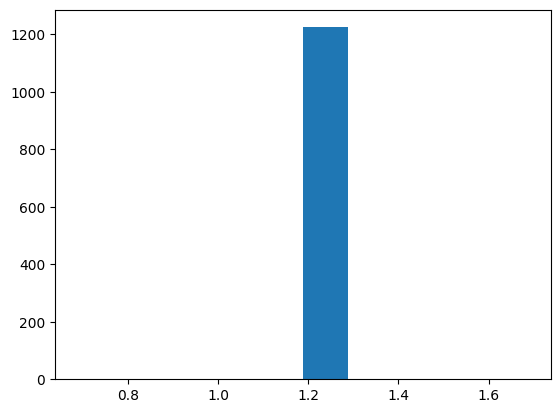

In [17]:
import matplotlib.pyplot as plt

plt.hist(y_pred)

In [18]:
y_train.iloc[null_indexes] = y_pred

In [19]:
y_train = np.round(y_train)

In [20]:
X_train = new_X_train.iloc[:, 1:]

In [21]:
reg_2 = LinearRegression()

reg_2.fit(X_train, y_train)

LinearRegression()

In [22]:
X_test_predict = X_test.loc[:, ['FGC-FGC_CU', 'Physical-Systolic_BP','Physical-Diastolic_BP']]

In [23]:
X_test_predict

,FGC-FGC_CU,Physical-Systolic_BP,Physical-Diastolic_BP
0,0.0,NaN,NaN
1,3.0,122.0,75.0
2,20.0,117.0,65.0
3,18.0,117.0,60.0
4,NaN,NaN,NaN
5,12.0,102.0,60.0
6,9.0,163.0,123.0
7,0.0,116.0,71.0
8,NaN,NaN,NaN
9,NaN,NaN,NaN


In [24]:
X_test_predict['Median_FGC-FGC_CU'] = X_test_predict['FGC-FGC_CU'].fillna(df_agg['Median_FGC-FGC_CU'].mean())

X_test_predict['Min_Physical-Systolic_BP'] = X_test_predict['Physical-Systolic_BP'].fillna(df_agg['Min_Physical-Systolic_BP'].mean())

X_test_predict['Min_Physical-Diastolic_BP'] = X_test_predict['Physical-Diastolic_BP'].fillna(df_agg['Min_Physical-Diastolic_BP'].mean())

In [25]:
X_test_predict = X_test_predict.loc[:, ['Median_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Min_Physical-Diastolic_BP']]

y_test = reg_2.predict(X_test_predict)

In [26]:
y_test

array([-3.13929670e-01,  4.02711689e-01,  2.12072203e+00,  1.90178370e+00,
        1.00325691e+00,  1.06647381e+00,  1.65483135e+00, -7.22774543e-04,
        1.00325691e+00,  1.00325691e+00,  1.00325691e+00,  1.00325691e+00,
        2.98177115e+00,  8.63789947e-01,  1.00325691e+00,  4.20411119e-01,
       -1.08697642e-01,  2.15271120e-01,  3.39425619e-01,  1.00325691e+00])

In [27]:
conditions = [y_test <= 0, y_test <= 1, y_test <= 2, y_test <= 3]

choices = [0, 1, 2, 3]

In [28]:
y_test_round = np.select(conditions, choices, default=1)

In [29]:
df_y_test = pd.DataFrame({'id': X_test['id'], 'sii': y_test_round})

In [30]:
X_test

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,26.1957,47.2211,NaN,NaN,Winter,3.670,Winter,27.0,40.0,Fall
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,28.7680,50.4767,NaN,NaN,Fall,1.270,NaN,NaN,NaN,Fall
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
from datetime import datetime

df_y_test.to_csv(f'submission.csv', index=False)

In [32]:
str(datetime.date(datetime.now()))+str(datetime.time(datetime.now()))

'2024-11-0301:09:07.847262'

In [33]:
df_y_test

,id,sii
0,00008ff9,0
1,000fd460,1
2,00105258,3
3,00115b9f,2
4,0016bb22,2
5,001f3379,2
6,0038ba98,2
7,0068a485,0
8,0069fbed,2
9,0083e397,2
